In [1]:
import nltk
import scipy
import utils as ut
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import re
from pytz import timezone
from datetime import datetime
import seaborn as sns
import tweets_process as tweets
from sklearn.feature_extraction.text import CountVectorizer

## Analyza textu: nejcastejsi slova

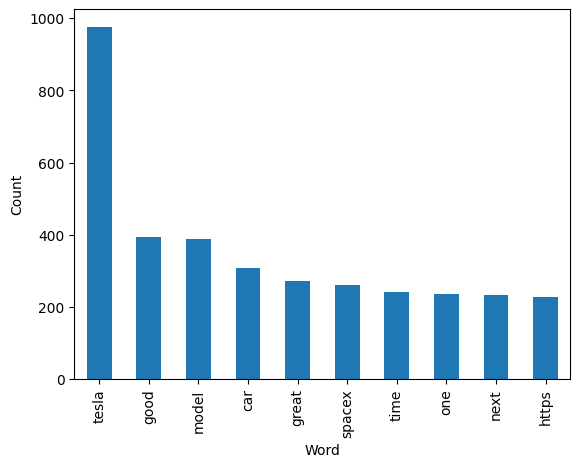

In [2]:
tweets.preprocess()
df = tweets.df
COUNT_TO_SHOW = 10
vectorizer = CountVectorizer(
    stop_words=['the', 'and', 'a', 'an', 'to', 'is', 'for', 'it', 'that', 'on', 'be', 'of', 'will', 'but', 'you',
                'this', 'are', 'in', 'we', 'not', 'at', 'so', 'by', 'as', 'have', 'with', 'yes', 'just', 'all',
                'from', 'no', 'was', 'or', 'if', 'more', 'there', 'can', 'about', 'com', 'do', 'like', 'my', 'than',
                'they', 're', 'has', 'would', 'should', 'what', 'our', 'much'])
X = vectorizer.fit_transform(df['text'].dropna())
word_count = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()).sum()
top_words = word_count.sort_values(ascending=False)[:COUNT_TO_SHOW]
top_words.plot(kind='bar')
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

## Analyza textu: distribuce intonace vety

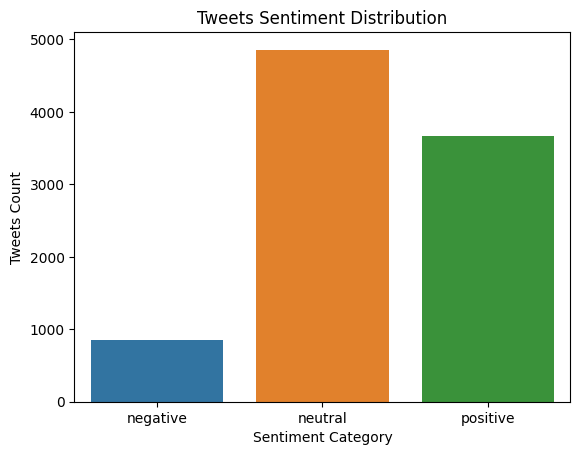

In [3]:
df['sentiment'] = df['text'].apply(tweets.sentiment_calc_bolb)
df['polarity'] = df['sentiment'].apply(lambda x: tuple(x)[0])
df['subjectivity'] = df['sentiment'].apply(lambda x: tuple(x)[1])
df['category'] = pd.cut(df['polarity'], bins=[-1, -0.1, 0.1, 1], labels=['negative', 'neutral', 'positive'])
df['positive'] = (df['category'] == 'positive')
df['negative'] = (df['category'] == 'negative')
df['neutral'] = (df['category'] == 'neutral')
df[['neutral', 'negative', 'positive']] = df[['neutral', 'negative', 'positive']].astype(int)
count = df['category'].value_counts()
sns.barplot(x=count.index, y=count.values)
plt.title('Tweets Sentiment Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Tweets Count')
plt.show()
df.drop(columns=['sentiment'], inplace=True)

## Analyza textu: pridani flagu, k cemu se tweet vztahuje

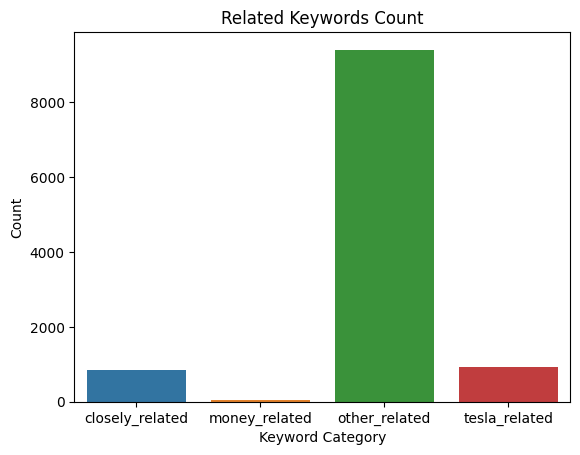

to                 467
text               927
retweets           927
Date               927
hashtags             3
mentions           109
urls               251
polarity           927
subjectivity       927
category           927
positive           927
negative           927
neutral            927
closely_related    927
money_related      927
other_related      927
tesla_related      927
dtype: int64

In [4]:
tesla = '[Tt]esla'
closely_related_keywords = r'Model [\w\d] | [Tt]ruck|[Ee]lectric|[Ss]olar|[Rr]oof|Semi|[Aa]uto(nomous|pilot|steer(ing)?)?|[Pp]anel|[Ee]nergy|[Mm]egapack | acceleration|top speed|brak(e|ing)'
money_related_keywords = r'[Aa]ffordable|[Cc]heap|[Ee]xpensive|[Pp]rice]|[Ss]tock'
other_related_keywords = r'[Ss]pace|[Mm]ars|[Ll]aunch|AI|neural|Boring Company|Hyperloop|[Ii]nterview|boringcompany |drive(ing)|[Tt]axi | |Cars? | cars? |'
df['closely_related'] = df['text'].apply(tweets.word_match_count, args=(closely_related_keywords,))
df['money_related'] = df['text'].apply(tweets.word_match_count, args=(money_related_keywords,))
df['other_related'] = df['text'].apply(tweets.word_match_count, args=(other_related_keywords,))
df['tesla_related'] = df['text'].apply(tweets.word_match_count, args=(tesla,))
counts = df[['closely_related', 'money_related', 'other_related', 'tesla_related']].astype(bool).sum()
sns.barplot(x=counts.index, y=counts.values)
plt.title('Related Keywords Count')
plt.xlabel('Keyword Category')
plt.ylabel('Count')
plt.show()
df[df['tesla_related'] != 0].count()

## Pridani info o url

In [5]:
reg = r'https?:\/\/([\w\d.]+)\/[\w\d\/\-\?\=]*'
news_keywords = r'wsj|news|forbes|bloomberg|finance|money|investopedia|marketwatch|cnbc|times|fortune|cnn|huffpost|cnn|usatoday|npr'
def get_domain(url):
    url = str(url)
    result =  re.search(reg, url)
    if result:
        return result.group(1)
    return None

df['url_domain'] = df['urls'].apply(get_domain)
df['url_news'] = df['url_domain'].fillna(0).str.contains(news_keywords, na=0).astype(int)
df['url_news'].fillna(0, inplace=True)
df['url_video'] = df['urls'].fillna(0).str.contains('video|youtube.com|watch', na=0).astype(int)
df['url_video'].fillna(0, inplace=True)
df.drop(['urls'], axis=1, inplace=True)
df.drop(['url_domain'], axis=1, inplace=True)

## Zpracovani sloupcu mentions a hashtags

In [6]:
df['hashtags_c'] = df['hashtags'].notnull()
df['mentions_c'] = df['mentions'].notnull()
df[['hashtags_c', 'mentions_c']] = df[['hashtags_c', 'mentions_c']].astype(int)
df.drop(columns=['mentions','hashtags' ], inplace=True)
df

,to,text,retweets,Date,polarity,subjectivity,category,positive,negative,neutral,closely_related,money_related,other_related,tesla_related,url_news,url_video,hashtags_c,mentions_c
0,NaN,Just test-fired the Superdraco rocket engine. ...,63,2012-02-01 16:03:05+00:00,0.000000,0.000000,neutral,0,0,1,0,0,96,0,0,0,0,0
1,NaN,"Um, while awesome in its own way, that was not...",5,2012-02-01 09:12:24+00:00,0.533333,0.700000,positive,1,0,0,0,0,125,0,0,0,0,0
2,NaN,The SpaceX theme song by Total Ghost is just t...,32,2012-01-31 16:49:58+00:00,0.350000,0.675000,positive,1,0,0,0,0,66,0,0,1,0,0
3,NaN,The lady doth protest too little. http://finan...,4,2012-01-28 19:54:40+00:00,-0.187500,0.500000,negative,0,1,0,0,0,119,0,1,0,0,0
4,NaN,The Model X unveiling will be webcast live on ...,109,2012-01-28 02:21:03+00:00,0.295455,0.666667,positive,1,0,0,1,0,128,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9402,flcnhvy,"Yeah, very important to provide C/BiPAP device...",137,2020-04-02 20:11:50+00:00,0.323333,0.716667,positive,1,0,0,0,0,153,0,0,0,0,0
9403,elonmusk,Invasive ventilators are for worst case patien...,349,2020-04-02 19:51:50+00:00,-0.500000,0.650000,negative,0,1,0,0,0,196,0,0,0,0,0
9404,28delayslater,"Exactly. Moreover, all hospitals were given ex...",417,2020-04-02 19:50:03+00:00,0.225000,0.575000,positive,1,0,0,0,0,153,0,0,0,0,0
9405,NuovaRealta,Will call when we reach Mars,809,2020-04-02 08:54:06+00:00,0.000000,0.000000,neutral,0,0,1,0,0,26,0,0,0,0,0


## Vytvareni sloupcu pro den v tydnu, cas a vymena indexu na datum

In [7]:
df['Date'] = pd.to_datetime( df['Date'], format='%Y-%m-%d %H:%M:%S')
df['Date'] = df['Date'].dt.tz_convert('EST')
df['day_of_week'] = df['Date'].dt.dayofweek
df['time_of_day'] = df['Date'].apply(lambda x: int(x.hour))
df.sort_index()
df


,to,text,retweets,Date,polarity,subjectivity,category,positive,negative,neutral,closely_related,money_related,other_related,tesla_related,url_news,url_video,hashtags_c,mentions_c,day_of_week,time_of_day
0,NaN,Just test-fired the Superdraco rocket engine. ...,63,2012-02-01 11:03:05-05:00,0.000000,0.000000,neutral,0,0,1,0,0,96,0,0,0,0,0,2,11
1,NaN,"Um, while awesome in its own way, that was not...",5,2012-02-01 04:12:24-05:00,0.533333,0.700000,positive,1,0,0,0,0,125,0,0,0,0,0,2,4
2,NaN,The SpaceX theme song by Total Ghost is just t...,32,2012-01-31 11:49:58-05:00,0.350000,0.675000,positive,1,0,0,0,0,66,0,0,1,0,0,1,11
3,NaN,The lady doth protest too little. http://finan...,4,2012-01-28 14:54:40-05:00,-0.187500,0.500000,negative,0,1,0,0,0,119,0,1,0,0,0,5,14
4,NaN,The Model X unveiling will be webcast live on ...,109,2012-01-27 21:21:03-05:00,0.295455,0.666667,positive,1,0,0,1,0,128,1,0,0,0,0,4,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9402,flcnhvy,"Yeah, very important to provide C/BiPAP device...",137,2020-04-02 15:11:50-05:00,0.323333,0.716667,positive,1,0,0,0,0,153,0,0,0,0,0,3,15
9403,elonmusk,Invasive ventilators are for worst case patien...,349,2020-04-02 14:51:50-05:00,-0.500000,0.650000,negative,0,1,0,0,0,196,0,0,0,0,0,3,14
9404,28delayslater,"Exactly. Moreover, all hospitals were given ex...",417,2020-04-02 14:50:03-05:00,0.225000,0.575000,positive,1,0,0,0,0,153,0,0,0,0,0,3,14
9405,NuovaRealta,Will call when we reach Mars,809,2020-04-02 03:54:06-05:00,0.000000,0.000000,neutral,0,0,1,0,0,26,0,0,0,0,0,3,3


## Seskupeni

In [8]:
df['day_of_week'] = df['Date'].dt.dayofweek
ut.convert_date_col(df, '%Y-%m-%d %H:%M:%S%z')
df.index = df['Date']
means_by_date = df[['polarity', 'subjectivity', 'time_of_day']].groupby(['Date']).mean()
sums_by_date = df[[ 'closely_related', 'retweets', 'money_related', 'other_related', 'tesla_related','url_news', 'url_video']].groupby(['Date']).sum()
df2 = pd.merge(sums_by_date, means_by_date, on='Date')
res = pd.merge(df[['category','to','text','mentions_c', 'hashtags_c', 'day_of_week','positive', 'negative', 'neutral']], df2, on='Date')
res

,category,to,text,mentions_c,hashtags_c,day_of_week,positive,negative,neutral,closely_related,retweets,money_related,other_related,tesla_related,url_news,url_video,polarity,subjectivity,time_of_day
Date,,,,,,,,,,,,,,,,,,,
2012-02-01,neutral,NaN,Just test-fired the Superdraco rocket engine. ...,0,0,2,0,0,1,0,68,0,221,0,0,0,0.266667,0.350000,7.500000
2012-02-01,positive,NaN,"Um, while awesome in its own way, that was not...",0,0,2,1,0,0,0,68,0,221,0,0,0,0.266667,0.350000,7.500000
2012-01-31,positive,NaN,The SpaceX theme song by Total Ghost is just t...,0,0,1,1,0,0,0,32,0,66,0,0,1,0.350000,0.675000,11.000000
2012-01-28,negative,NaN,The lady doth protest too little. http://finan...,0,0,5,0,1,0,0,4,0,119,0,1,0,-0.187500,0.500000,14.000000
2012-01-27,positive,NaN,The Model X unveiling will be webcast live on ...,0,0,4,1,0,0,1,211,0,183,1,0,0,0.394318,0.696970,18.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-02,negative,elonmusk,Weird that so many troll/bot accounts were act...,0,0,3,0,1,0,0,3876,0,1135,0,0,0,0.115595,0.400952,16.714286
2020-04-02,positive,flcnhvy,"Yeah, very important to provide C/BiPAP device...",0,0,3,1,0,0,0,3876,0,1135,0,0,0,0.115595,0.400952,16.714286
2020-04-02,negative,elonmusk,Invasive ventilators are for worst case patien...,0,0,3,0,1,0,0,3876,0,1135,0,0,0,0.115595,0.400952,16.714286


In [9]:
res.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9407 entries, 2012-02-01 to 2020-04-02
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   category         9374 non-null   category
 1   to               6717 non-null   object  
 2   text             9314 non-null   object  
 3   mentions_c       9407 non-null   int32   
 4   hashtags_c       9407 non-null   int32   
 5   day_of_week      9407 non-null   int64   
 6   positive         9407 non-null   int32   
 7   negative         9407 non-null   int32   
 8   neutral          9407 non-null   int32   
 9   closely_related  9407 non-null   int64   
 10  retweets         9407 non-null   int64   
 11  money_related    9407 non-null   int64   
 12  other_related    9407 non-null   int64   
 13  tesla_related    9407 non-null   int64   
 14  url_news         9407 non-null   int32   
 15  url_video        9407 non-null   int32   
 16  polarity         9407 non-null  

In [10]:
ut.write_data_frame_to_csv('tweets-prepared-to-analyze.csv', res)
ut.write_data_frame_to_csv('tweets-v1.csv', df)

Write to file ../data/tweets-prepared-to-analyze.csv
Write to file ../data/tweets-prepared-to-analyze.csv: DONE
Write to file ../data/tweets-v1.csv
Write to file ../data/tweets-v1.csv: DONE
